In [4]:
import os
import json
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint

In [5]:

def flatten_dict(d):
    r = {}
    q = [("", x) for x in d.items()]
    while len(q) > 0:
        p, (k, v) = q.pop(0)
        if type(v) is not dict:
            r[f"{p}{k}".lower()] = v
        else:
            for x in v.items():
                q.append((f"{p}{k}_", x))
    return r


def parse_partial_results_ndt7(f):
    TestStage = None
    result_dicts = []
    for line in f:
        line_dict = json.loads(line)
        if "Key" in line_dict:
            k = line_dict["Key"]
            v = line_dict["Value"]
            if k == "connected":
                if v["Test"] == "download":
                    TestStage = "Download"
                elif v["Test"] == "upload":
                    TestStage = "Upload"
            elif k == "complete":
                TestStage = None
            # elif TestStage == "Download" and k == "measurement":
            elif TestStage == "Upload" and k == "measurement":
                if "TCPInfo" in v:
                    v["TCPInfo"]["TestStage"] = TestStage
                    result_dicts.append(v["TCPInfo"])
        # pprint(line_dict)
    # final_results_line = f.readlines()[-1]
    # return flatten_dict(json.loads(final_results_line))
    return result_dicts


def load_experiment_results(exp_dir):
    file_dicts = []
    for subdir in os.listdir(exp_dir):
        if "lan3" not in subdir:
            continue
        splitted_subdir = subdir.split("_")
        speed = splitted_subdir[1]
        latency = splitted_subdir[2]
        pktloss = splitted_subdir[3]
        aqm = '_'.join(splitted_subdir[4:])
        subdir_path = os.path.join(exp_dir, subdir)
        for filename in os.listdir(subdir_path):
            datetime = pd.to_datetime(re.split(r'_|\.', filename)[1])
            filepath = os.path.join(subdir_path, filename)
            with open(filepath) as f:
                rs = parse_partial_results_ndt7(f)
            for r in rs:
                r["speed"] = speed
                r["latency"] = latency
                r["pktloss"] = pktloss
                r["aqm"] = aqm
                r["datetime"] = datetime
            file_dicts = file_dicts + rs
            # break
        # break

    return pd.DataFrame(file_dicts)


exp_dir = "../data/data_json_3/"
partial_df = load_experiment_results(exp_dir)

In [102]:
partial_df.columns

Index(['State', 'CAState', 'Retransmits', 'Probes', 'Backoff', 'Options',
       'WScale', 'AppLimited', 'RTO', 'ATO', 'SndMSS', 'RcvMSS', 'Unacked',
       'Sacked', 'Lost', 'Retrans', 'Fackets', 'LastDataSent', 'LastAckSent',
       'LastDataRecv', 'LastAckRecv', 'PMTU', 'RcvSsThresh', 'RTT', 'RTTVar',
       'SndSsThresh', 'SndCwnd', 'AdvMSS', 'Reordering', 'RcvRTT', 'RcvSpace',
       'TotalRetrans', 'PacingRate', 'MaxPacingRate', 'BytesAcked',
       'BytesReceived', 'SegsOut', 'SegsIn', 'NotsentBytes', 'MinRTT',
       'DataSegsIn', 'DataSegsOut', 'DeliveryRate', 'BusyTime', 'RWndLimited',
       'SndBufLimited', 'Delivered', 'DeliveredCE', 'BytesSent',
       'BytesRetrans', 'DSackDups', 'ReordSeen', 'RcvOooPack', 'SndWnd',
       'ElapsedTime', 'TestStage', 'speed', 'latency', 'pktloss', 'aqm',
       'datetime'],
      dtype='object')

In [133]:

def generate_tput_timeseries_plots(df, result_col, result_label):
    fig, axes = plt.subplots(9, 3, figsize=(4*3, 4*9))
    for i, (speed, speed_df) in enumerate(sorted(df.groupby("speed"))):
        miny = None
        maxy = None
        for j, (aqm, aqm_df) in enumerate(sorted(speed_df.groupby("aqm"))):
            ax = axes[i][j]
            for _, ddf in aqm_df.groupby("datetime"):
                ddf = ddf.sort_values("ElapsedTime")
                elapsed_time = ddf["ElapsedTime"]/1e6
                interval = ddf["ElapsedTime"].values - pd.concat([pd.Series([0]), ddf["ElapsedTime"][:-1]]).values
                deltabytes = ddf[result_col].values - pd.concat([pd.Series([0]), ddf[result_col][:-1]]).values
                y = ((deltabytes*8)/1e6)/(interval/1e6)
                ax.plot(elapsed_time, y, color="blue", alpha=2/aqm_df["datetime"].nunique())
                if miny is None or miny > y.min():
                    miny = y.min()
                if maxy is None or maxy < y.max():
                    maxy = y.max()
            ax.set_title(f"<{speed} Mbps, {aqm}>")
            ax.set_xlabel("Elapsed Time")
            ax.set_ylabel(result_label)
        offset = (maxy - miny)*0.05
        for j in range(speed_df["aqm"].nunique()):
            axes[i][j].set_ylim(miny - offset, maxy + offset)
    plt.tight_layout()
    plt.show()
    return fig


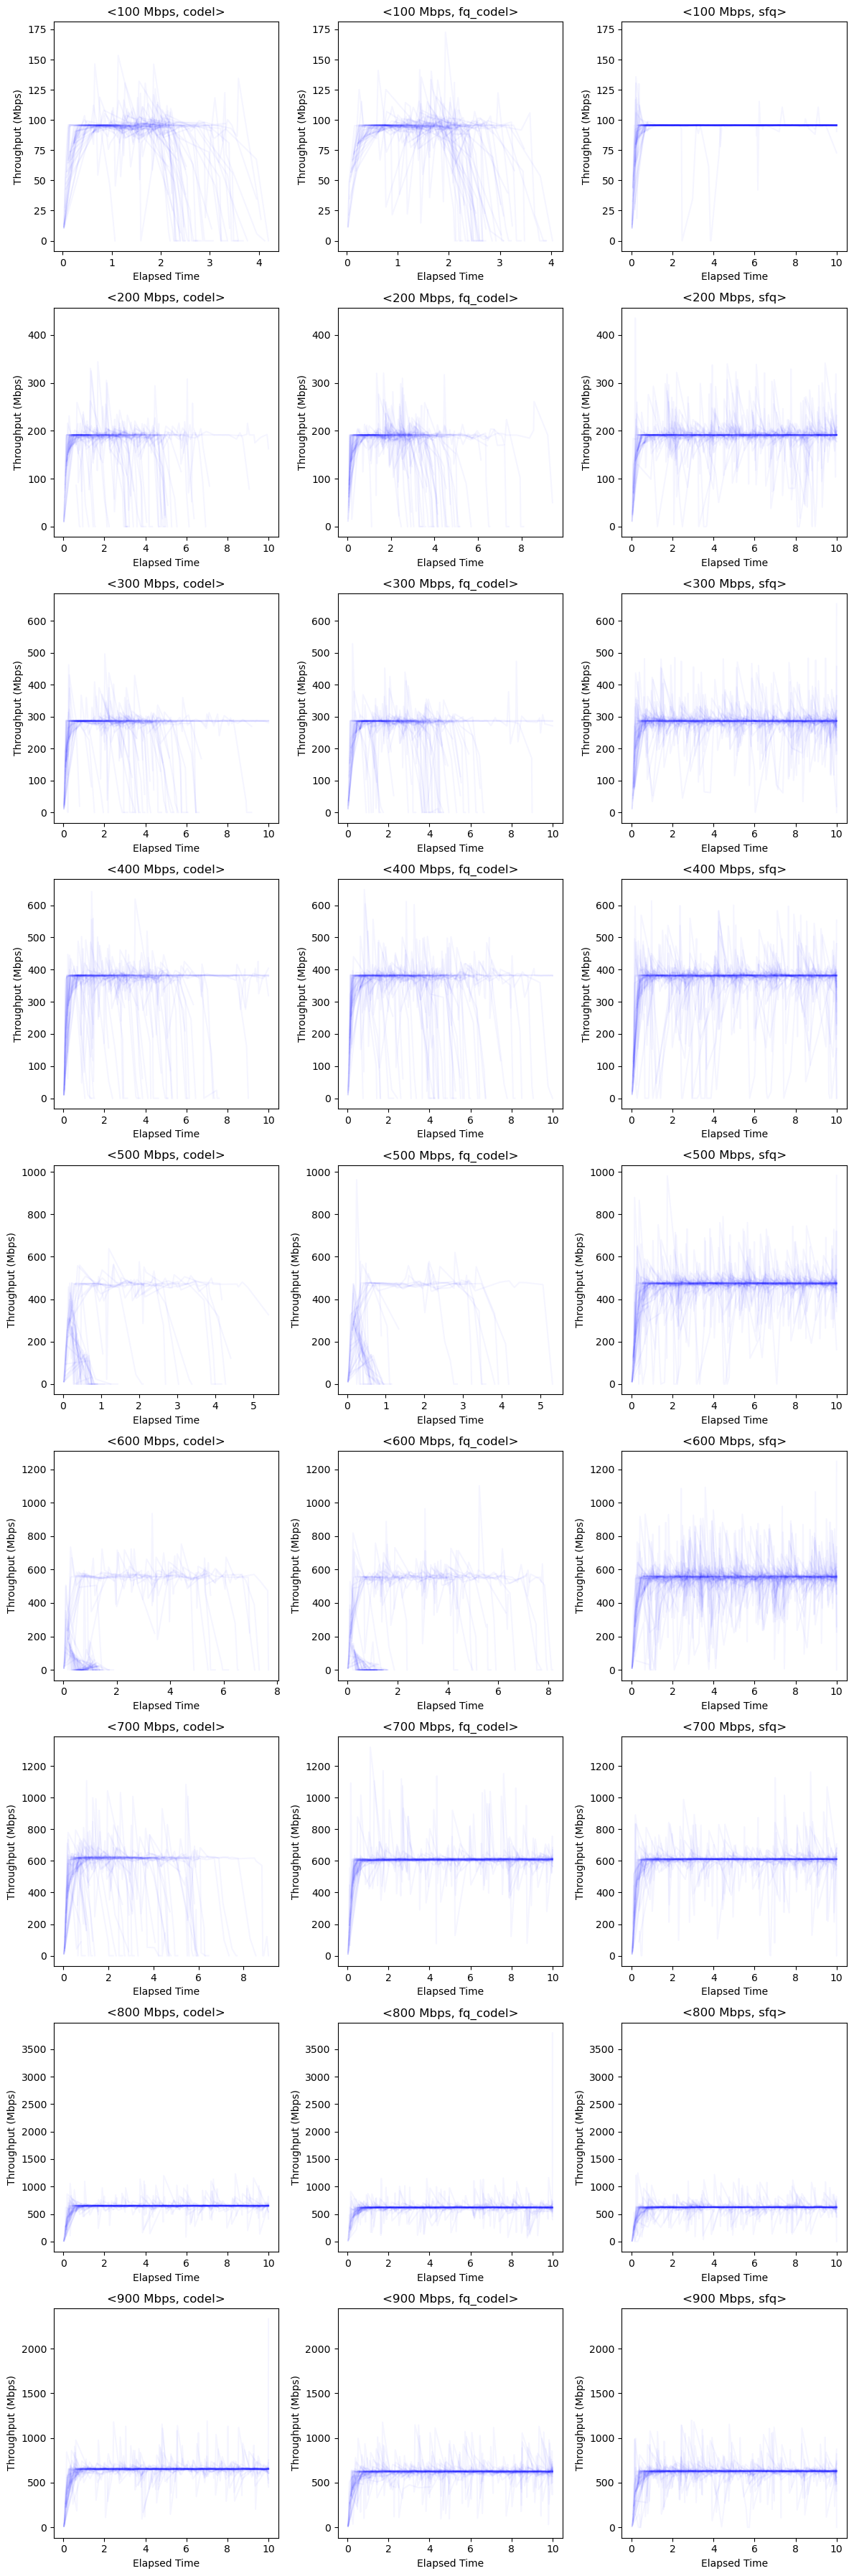

In [ ]:
fig = generate_tput_timeseries_plots(partial_df, "BytesReceived", "Throughput (Mbps)")

fig.savefig("figures/instant_tput.png")

In [ ]:
def generate_rtt_timeseries_plots(df, result_col, result_label):
    fig, axes = plt.subplots(9, 3, figsize=(4*3, 4*9))
    for i, (speed, speed_df) in enumerate(sorted(df.groupby("speed"))):
        miny = None
        maxy = None
        for j, (aqm, aqm_df) in enumerate(sorted(speed_df.groupby("aqm"))):
            ax = axes[i][j]
            for _, ddf in aqm_df.groupby("datetime"):
                ddf = ddf.sort_values("ElapsedTime")
                elapsed_time = ddf["ElapsedTime"]/1e6
                y = ddf[result_col]/1e3
                ax.plot(elapsed_time, y, color="blue", alpha=2/aqm_df["datetime"].nunique())
                if miny is None or miny > y.min():
                    miny = y.min()
                if maxy is None or maxy < y.max():
                    maxy = y.max()
            ax.set_title(f"<{speed} Mbps, {aqm}>")
            ax.set_xlabel("Elapsed Time")
            ax.set_ylabel(result_label)
        offset = (maxy - miny)*0.05
        for j in range(speed_df["aqm"].nunique()):
            axes[i][j].set_ylim(miny - offset, maxy + offset)
    plt.tight_layout()
    plt.show()
    return fig


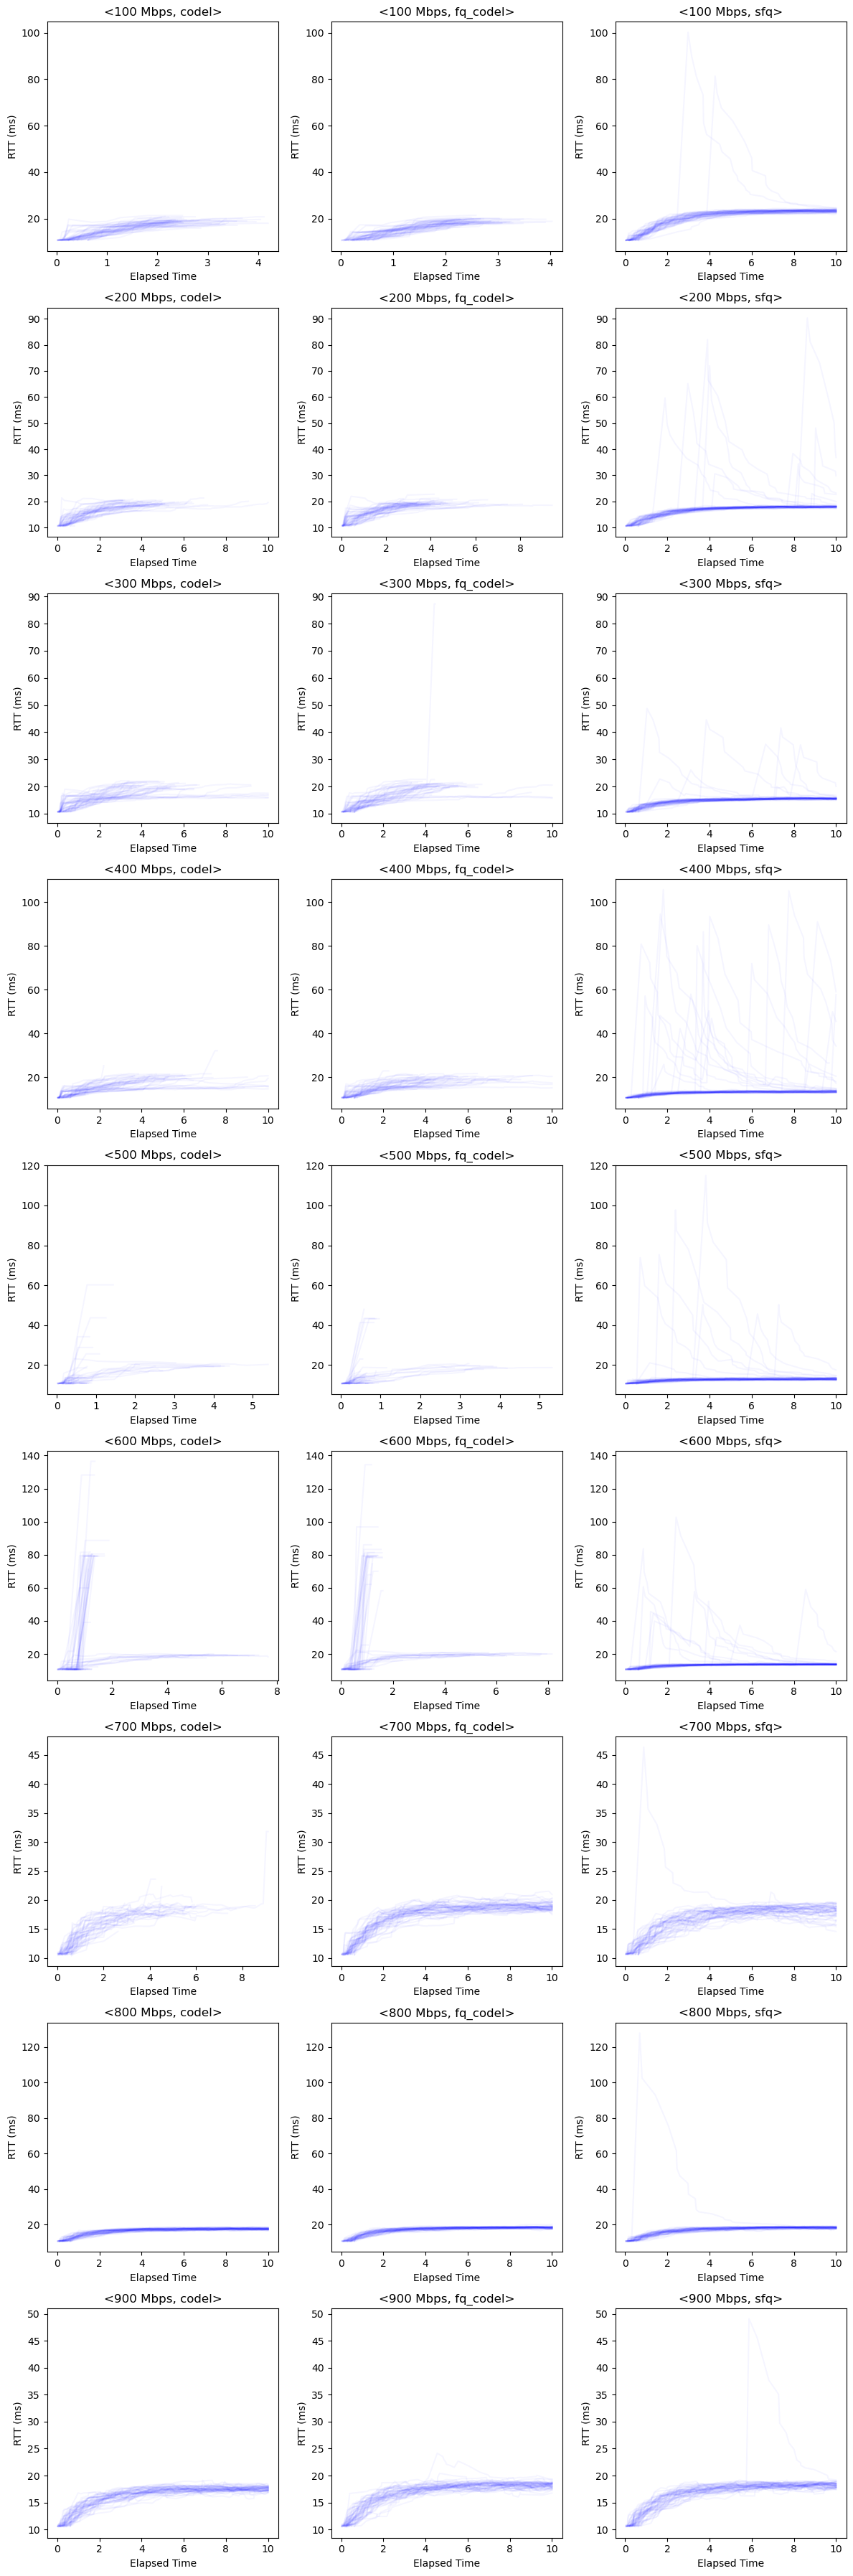

In [ ]:
fig = generate_rtt_timeseries_plots(partial_df, "RTT", "RTT (ms)")

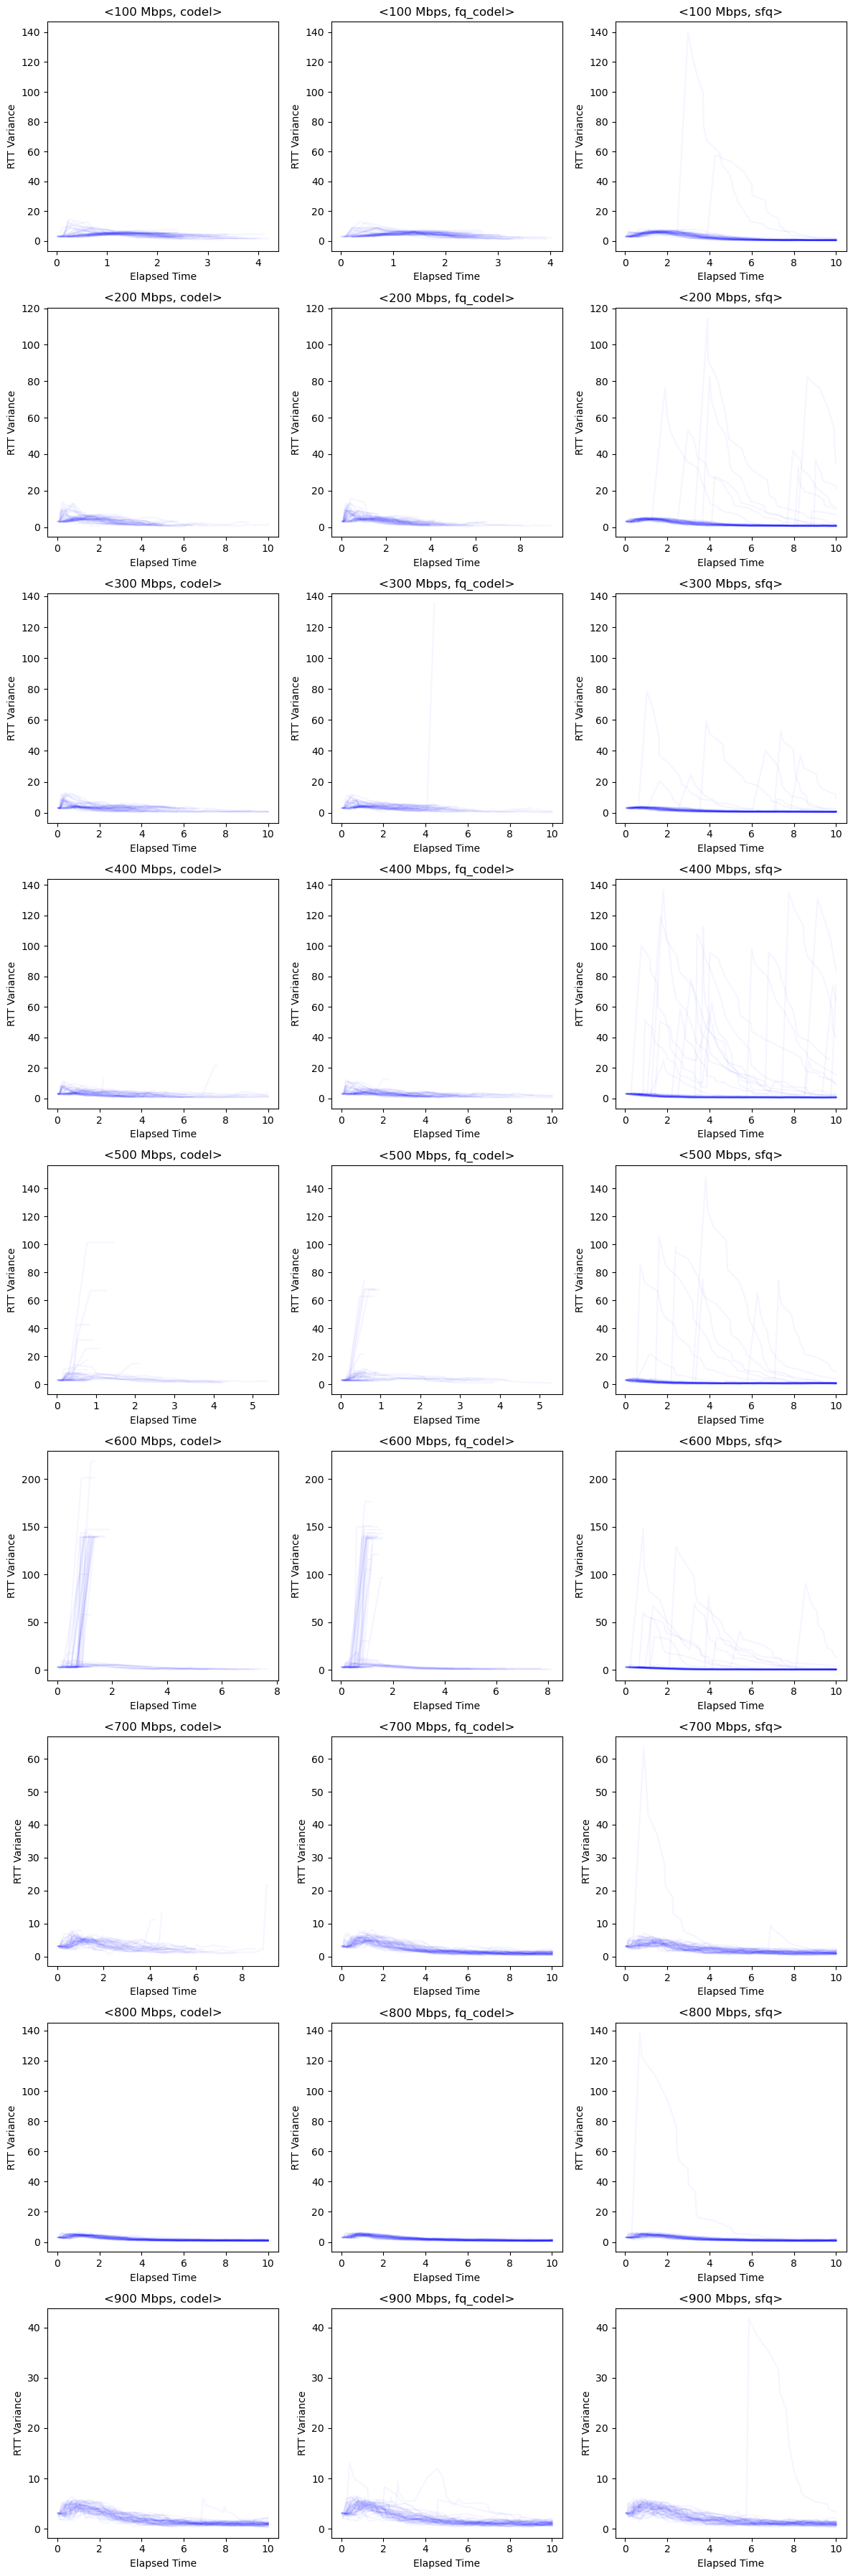

In [132]:
generate_rtt_timeseries_plots(partial_df, "RTTVar", "RTT Variance")

In [ ]:
def generate_loss_timeseries_plots(df, result_col, result_label):
    for speed, speed_df in sorted(df.groupby("speed")):
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        fig.suptitle(f"Bandwidth: {speed} Mbps")
        for i, (aqm, aqm_df) in enumerate(sorted(speed_df.groupby("aqm"))):
            ax = axes[i]
            for _, ddf in aqm_df.groupby("datetime"):
                ddf = ddf.sort_values("ElapsedTime")
                elapsed_time = ddf["ElapsedTime"]/1e6
                latency = ddf[result_col]
                ax.plot(elapsed_time, latency, color="blue", alpha=2/aqm_df["datetime"].nunique())
            ax.set_title(f"AQM: {aqm}")
            ax.set_xlabel("Elapsed Time")
            ax.set_ylabel(result_label)
        plt.tight_layout()
        plt.show()
    return fig


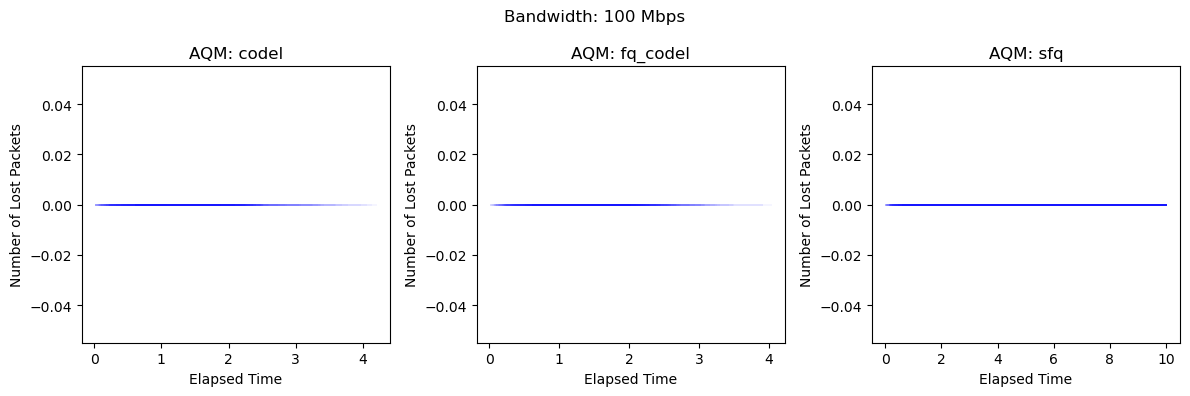

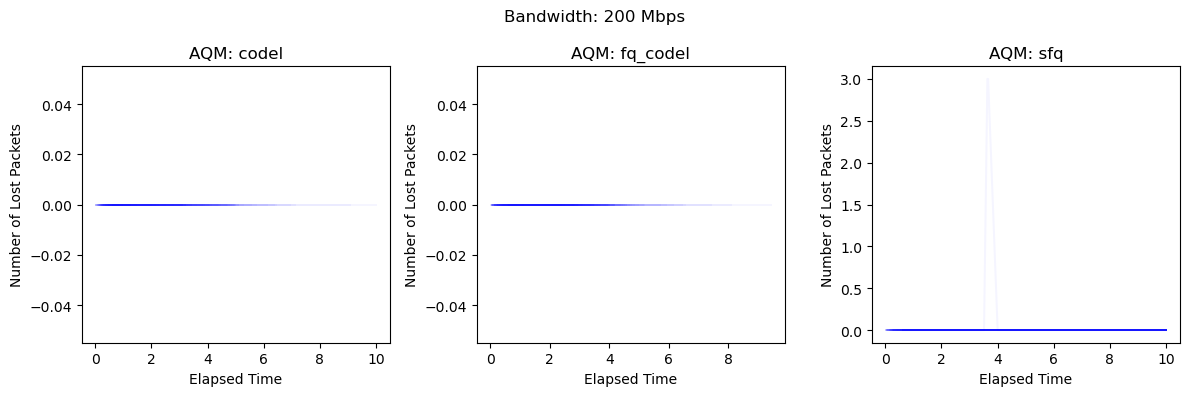

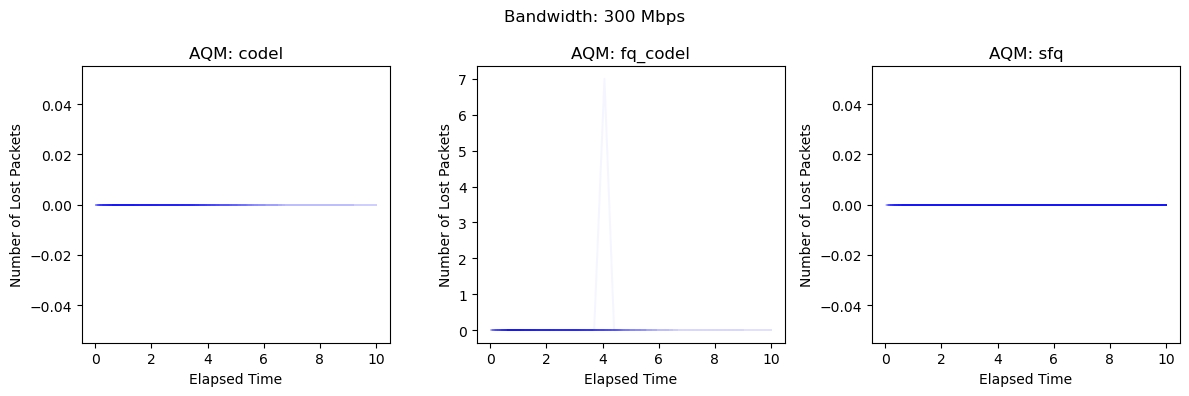

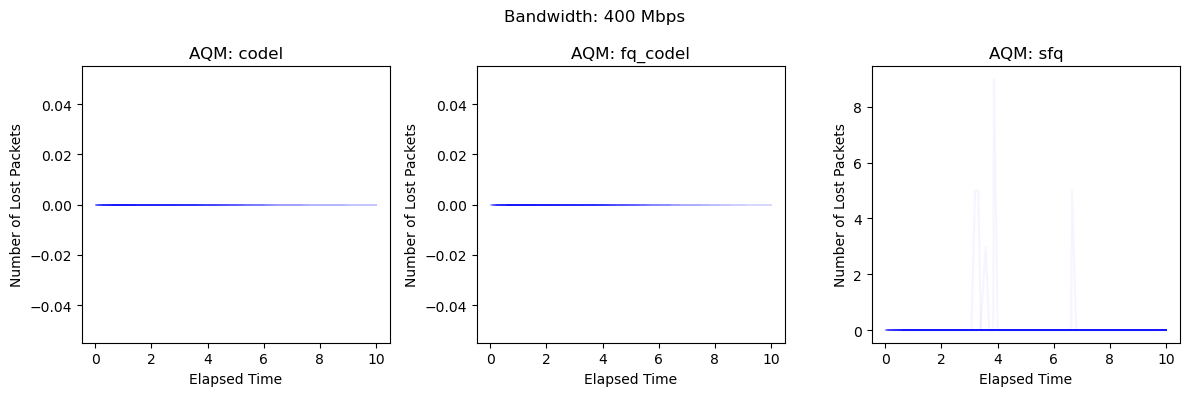

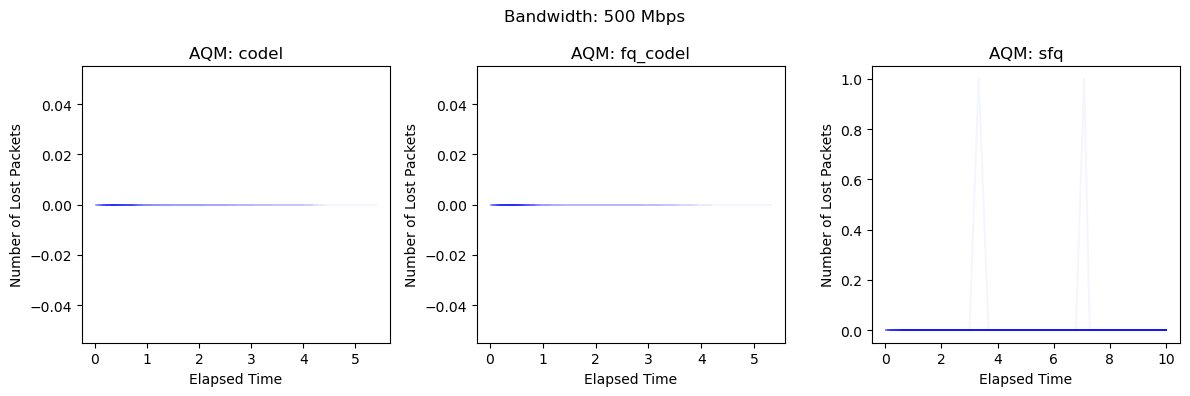

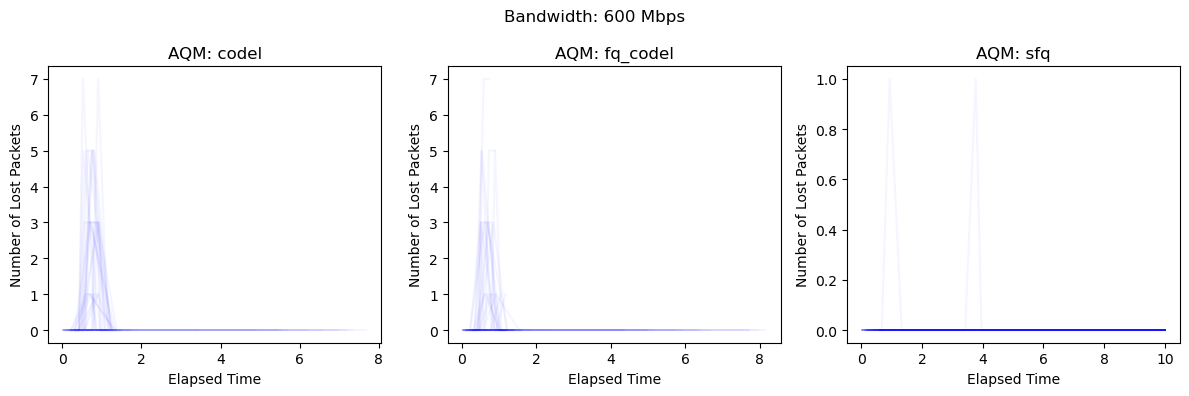

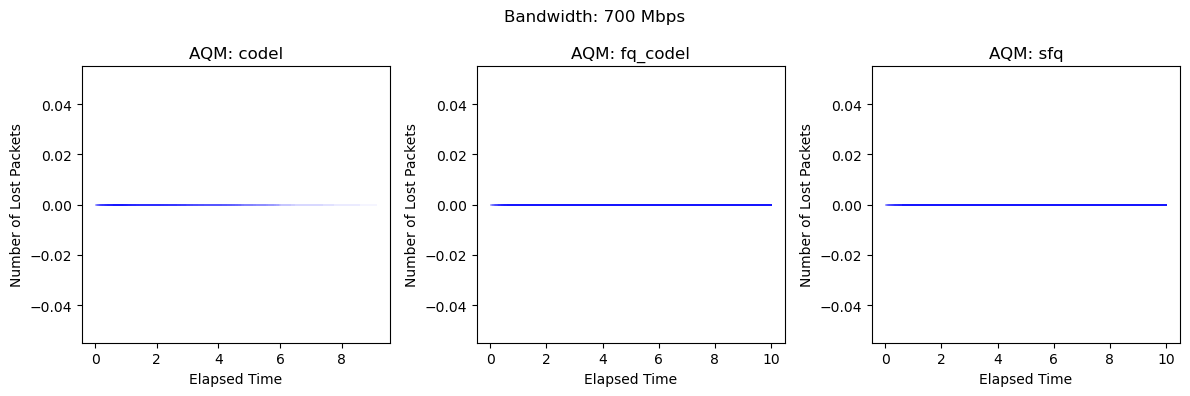

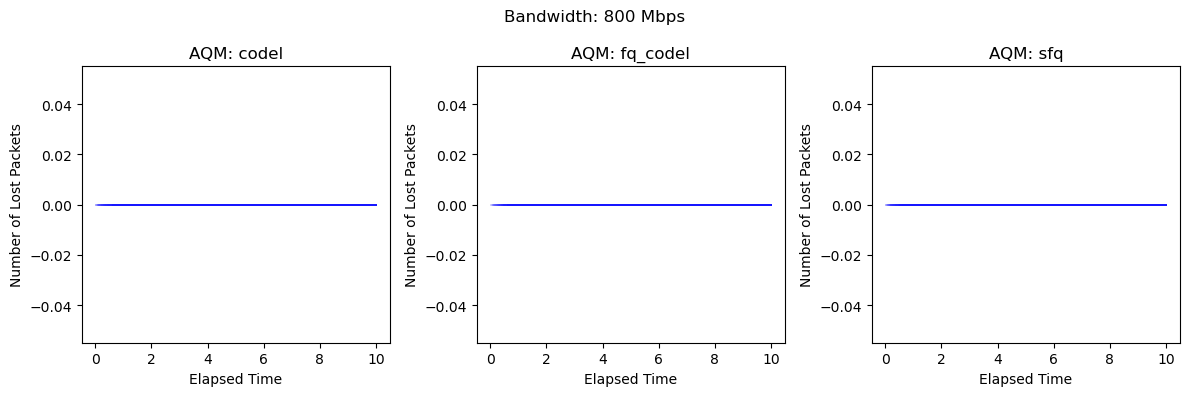

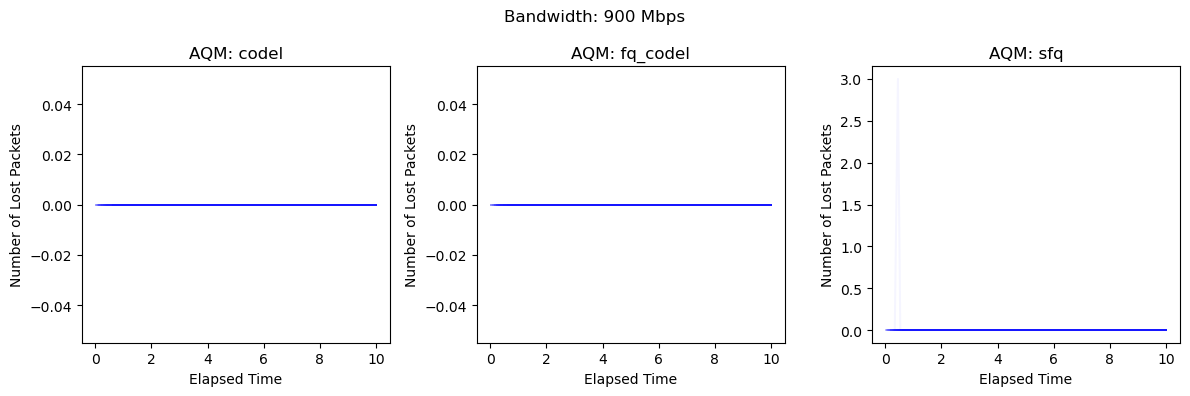

In [ ]:
fig = generate_loss_timeseries_plots(partial_df, "Lost", "Number of Lost Packets")

In [137]:
def generate_ecdfs_testduration(df):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    lss = ['--', '-.', ':']
    for i, (speed, speed_df) in enumerate(sorted(df.groupby("speed"))):
        ax = axes[i//3][i%3]
        for j, (aqm, aqm_df) in enumerate(sorted(speed_df.groupby("aqm"))):
            xs = []
            for _, ddf in aqm_df.groupby("datetime"):
                xs.append(ddf["ElapsedTime"].max()/1e6)
            sns.ecdfplot(xs, label=aqm, ls=lss[j], ax=ax)
        ax.set_title(f"Bandwidth: {speed} Mbps")
        ax.set_xlabel("Test Duration")
        ax.set_ylabel("CDF")
        ax.set_xlim(-1, 11)
        ax.legend()
    plt.tight_layout()
    plt.show()
    return fig


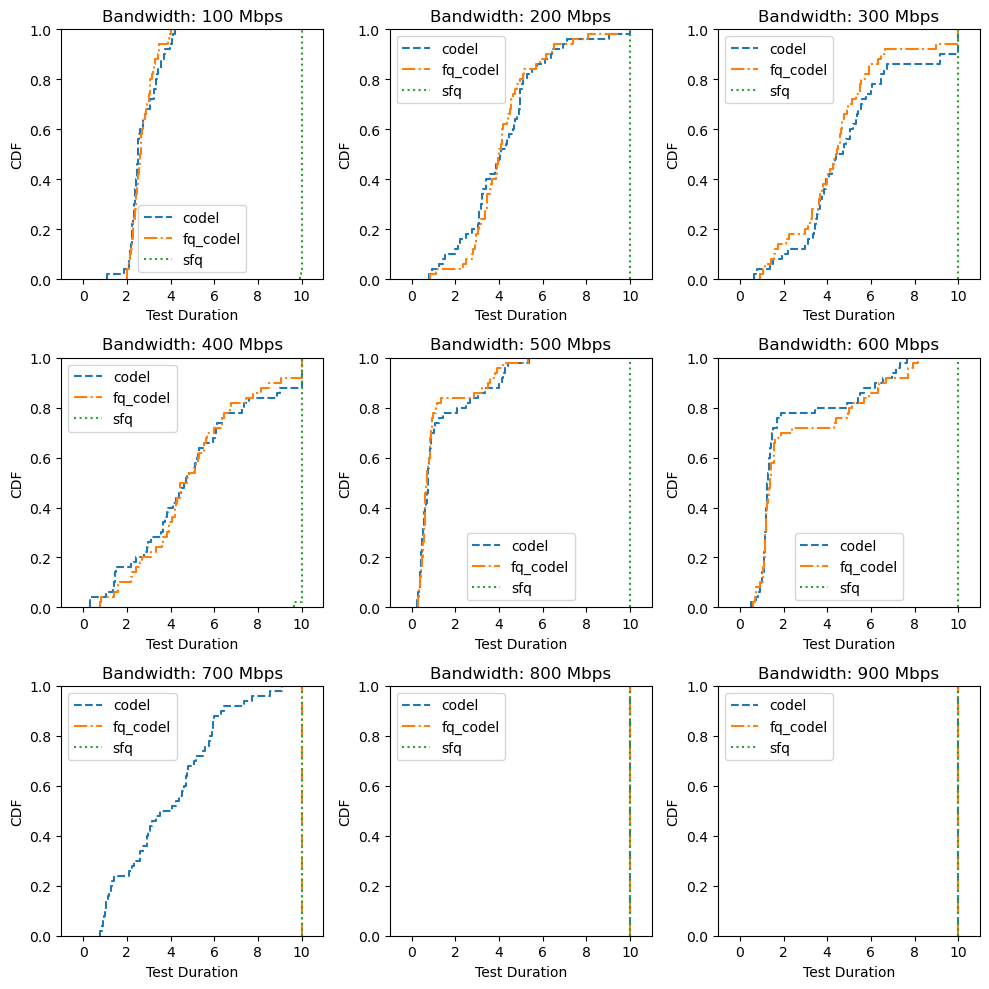

In [ ]:
fig = generate_ecdfs_testduration(partial_df)

fig.savefig("figures/test_duration.png")